In [1]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [2]:
df = pd.read_excel('C:/Users/ADMIN/Desktop/capstone project/Sales Forecast_Sales_Forecast_Data.xlsx')

In [3]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [5]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2017-06-01'
test_start_date = '2017-07-01'
test_end_date = '2017-12-01'
consider_rolling_window = True
consider_mean_values = False
predict_periods=6
missing_record_index = 37

In [6]:
if consider_rolling_window == True:
    rolling_period = 5
else:
    #do not change this value
    rolling_period = 1     

In [7]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [8]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [9]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [10]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
#Considering only Himachal Pradesh data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Himachal Pradesh')]
ABC_df

FIN_YEAR      MONTH             STATE            FG  DISTRICT  \
141        2014 2014-07-01  Himachal Pradesh  Insecticides    Kangra   
142        2014 2014-07-01  Himachal Pradesh  Insecticides     Kullu   
143        2014 2014-07-01  Himachal Pradesh  Insecticides     Mandi   
144        2014 2014-07-01  Himachal Pradesh  Insecticides  Hamirpur   
145        2014 2014-07-01  Himachal Pradesh  Insecticides  Bilaspur   
...         ...        ...               ...           ...       ...   
229553     2016 2016-12-01  Himachal Pradesh  Bactericides    Shimla   
229877     2016 2016-10-01  Himachal Pradesh  Bactericides  Hamirpur   
229878     2016 2016-10-01  Himachal Pradesh  Bactericides    Kangra   
229879     2016 2016-10-01  Himachal Pradesh  Bactericides    Kangra   
229882     2016 2016-10-01  Himachal Pradesh  Bactericides     Mandi   

                  COMPANY     VALUE  
141     ABC Manufacturing  3075.300  
142     ABC Manufacturing    89.100  
143     ABC Manufacturing  1561.005  
144     ABC Manufacturing   133.650  
145     ABC Manufacturing  2568.915  
...                   ...       ...  
229553  ABC Manufacturing     0.000  
229877  ABC Manufacturing     0.000  
229878  ABC Manufacturing     0.000  
229879  ABC Manufacturing     0.000  
229882  ABC Manufacturing     0.000  

[3880 rows x 7 columns]

In [12]:
ABC_df.describe()

VALUE
count  3880.000000
mean    158.685646
std     507.967772
min       0.000000
25%       0.000000
50%       0.000000
75%      67.500000
max    6709.500000

In [13]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [14]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [15]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':12270.105}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':13035.15}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [16]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':196}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':218}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [17]:
ABC_df_Pesticides

MONTH      VALUE
0   2014-01-01 00:00:00  21497.670
1   2014-02-01 00:00:00  12344.535
2   2014-03-01 00:00:00   2396.790
3   2014-04-01 00:00:00   6969.780
4   2014-05-01 00:00:00  10023.480
5   2014-06-01 00:00:00  18159.390
6   2014-07-01 00:00:00  14409.630
7   2014-08-01 00:00:00   7495.875
8   2014-09-01 00:00:00    165.375
9   2014-10-01 00:00:00  13826.835
10  2014-11-01 00:00:00  24801.930
11  2014-12-01 00:00:00  16783.740
12  2015-01-01 00:00:00  15356.250
13  2015-02-01 00:00:00   8318.295
14  2015-03-01 00:00:00  21547.080
15  2015-04-01 00:00:00  16622.820
16  2015-05-01 00:00:00   7457.400
17  2015-06-01 00:00:00  21232.530
18  2015-07-01 00:00:00  14526.675
19  2015-08-01 00:00:00  14110.470
20  2015-09-01 00:00:00  16156.800
21  2015-10-01 00:00:00  21325.950
22  2015-11-01 00:00:00  14076.855
23  2015-12-01 00:00:00  16709.220
24  2016-01-01 00:00:00   7311.870
25  2016-02-01 00:00:00  16147.485
26  2016-03-01 00:00:00  15161.580
27  2016-04-01 00:00:00   1407.780
28  2016-05-01 00:00:00  15280.110
29  2016-06-01 00:00:00  15497.595
30  2016-07-01 00:00:00  14288.805
31  2016-08-01 00:00:00   7198.335
32  2016-09-01 00:00:00  24069.150
33  2016-10-01 00:00:00  18596.250
34  2016-11-01 00:00:00  13007.385
35  2016-12-01 00:00:00  11162.610
36  2017-01-01 00:00:00  15490.440
37           2017-02-01  12270.105
38           2017-03-01  13035.150
37  2017-04-01 00:00:00   7897.095
38  2017-05-01 00:00:00  10102.455
39  2017-06-01 00:00:00   6543.450
40  2017-07-01 00:00:00  17274.870
41  2017-08-01 00:00:00   2613.465
42  2017-09-01 00:00:00  11216.475
43  2017-10-01 00:00:00    512.595
44  2017-11-01 00:00:00  26836.380
45  2017-12-01 00:00:00  21768.750

<AxesSubplot:xlabel='MONTH', ylabel='VALUE'>

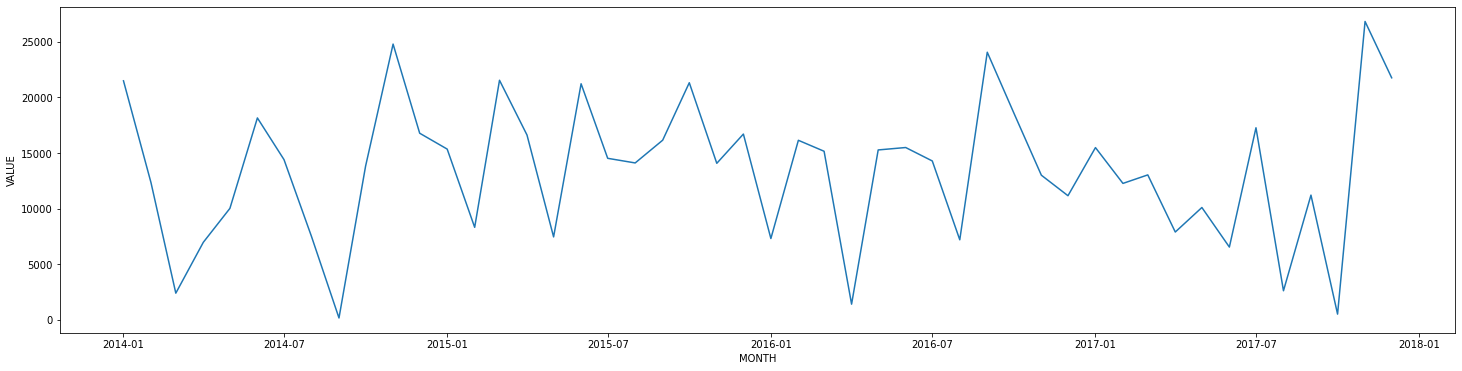

In [18]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

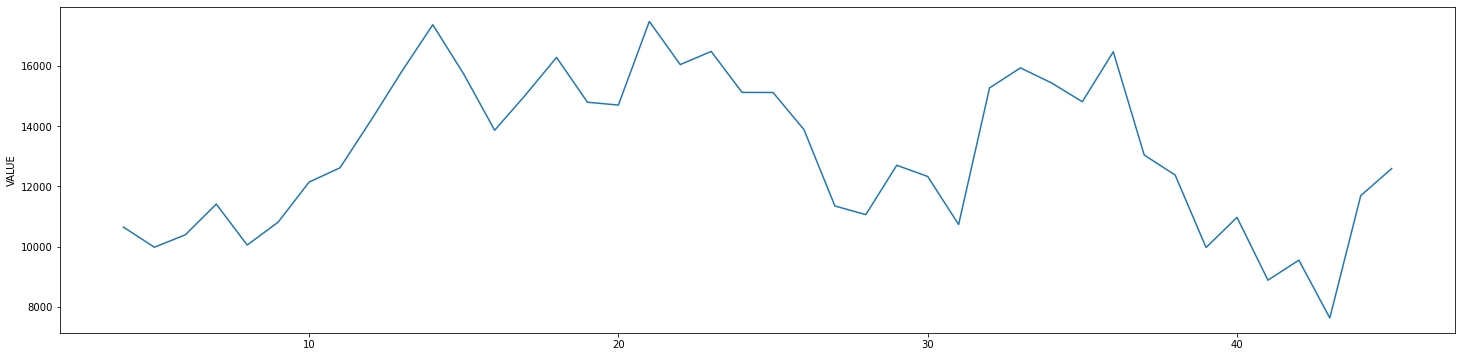

In [19]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

[Text(1, 0, 'VALUE')]

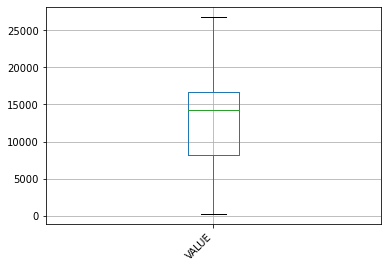

In [20]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [21]:
ABC_df_Pesticides.describe()

VALUE
count     48.000000
mean   13354.282500
std     6414.494717
min      165.375000
25%     8212.995000
50%    14199.637500
75%    16727.850000
max    26836.380000

In [22]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

23264.010000000002


In [23]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [24]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [25]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [26]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [27]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -3.815
P-value = 0.003
Critical values :
	1%: -3.610399601308181 - The data is  stationary with 99% confidence
	5%: -2.939108945868946 - The data is  stationary with 95% confidence
	10%: -2.6080629651545038 - The data is  stationary with 90% confidence


In [28]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [29]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.16941527598278028
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [30]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [31]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 4 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   44 non-null     object 
 1   VALUE   44 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [32]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [33]:
ABC_df_Pesticides

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

<AxesSubplot:xlabel='MONTH'>

<Figure size 2160x2520 with 0 Axes>

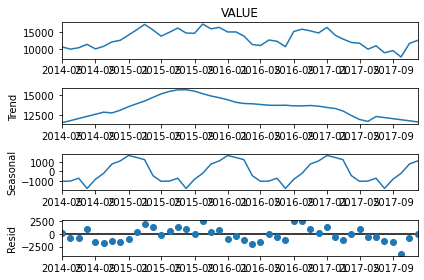

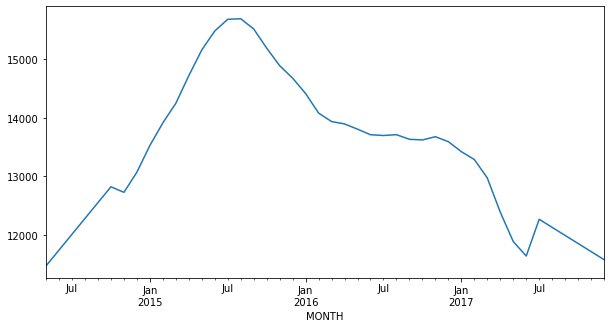

In [34]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [35]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [36]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [37]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds          y
0  2014-05-01  10646.451
1  2014-06-01   9978.795
2  2014-07-01  10391.814
3  2014-08-01  11411.631
4  2014-09-01  10050.750
5  2014-10-01  10811.421
6  2014-11-01  12139.929
7  2014-12-01  12614.751
8  2015-01-01  14186.826
9  2015-02-01  15817.410
10 2015-03-01  17361.459
11 2015-04-01  15725.637
12 2015-05-01  13860.369
13 2015-06-01  15035.625
14 2015-07-01  16277.301
15 2015-08-01  14789.979
16 2015-09-01  14696.775
17 2015-10-01  17470.485
18 2015-11-01  16039.350
19 2015-12-01  16475.859
20 2016-01-01  15116.139
21 2016-02-01  15114.276
22 2016-03-01  13881.402
23 2016-04-01  11347.587
24 2016-05-01  11061.765
25 2016-06-01  12698.910
26 2016-07-01  12327.174
27 2016-08-01  10734.525
28 2016-09-01  15266.799
29 2016-10-01  15930.027
30 2016-11-01  15431.985
31 2016-12-01  14806.746
32 2017-01-01  16465.167
33 2017-02-01  14105.358
34 2017-03-01  12993.138
35 2017-04-01  11971.080
36 2017-05-01  11759.049
37 2017-06-01   9969.651

In [38]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds          y
38 2017-07-01  10970.604
39 2017-08-01   8886.267
40 2017-09-01   9550.143
41 2017-10-01   7632.171
42 2017-11-01  11690.757
43 2017-12-01  12589.533

In [39]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [40]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [41]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [42]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
m.params

{'k': array([[0.04719958]]),
 'm': array([[0.7414833]]),
 'delta': array([[ 7.64633030e-11,  7.32964446e-12, -9.73318602e-11,
          5.12003545e-11, -1.48890348e-12, -7.01139683e-11,
         -1.94122243e-10, -2.43291795e-06, -1.76399091e-05,
         -1.15109143e-04, -4.07944312e-07, -7.19955098e-04,
         -5.80817971e-04, -1.47368343e-04, -1.44864487e-04,
         -2.19719478e-04, -2.23627979e-04, -1.27636651e-04,
         -8.42086026e-05, -4.18912680e-10, -2.42383185e-09,
         -1.34373546e-10, -3.37223247e-10, -1.47112145e-10,
          6.07676530e-11]]),
 'sigma_obs': array([[0.102251]]),
 'beta': array([[-0.02742106,  0.06334548,  0.04890005,  0.03072877,  0.45550666,
         -0.32546491,  0.02384426,  0.11437252, -0.00409091, -0.20363819,
          0.4555765 ,  0.0349171 , -0.01789435,  0.18229122,  0.0302407 ,
         -0.10938632,  0.37665486,  0.37222904,  0.07725238, -0.02768355]]),
 'trend': array([[0.7414833 , 0.7427816 , 0.74403803, 0.74533633, 0.74663463,
     

In [44]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0  2014-05-01  11256.114332   7703.225295  14496.925784
1  2014-06-01  11373.464305   7912.258631  14821.765878
2  2014-07-01  12762.156942   9201.816350  16500.778939
3  2014-08-01  12277.966568   8598.475353  15862.382899
4  2014-09-01  12825.700476   9294.930451  16271.440307
5  2014-10-01  14505.865570  11044.010421  17993.061915
6  2014-11-01  14312.107803  10735.490254  17644.549359
7  2014-12-01  14530.404551  10628.332355  17992.577737
8  2015-01-01  14790.066203  11289.553178  18338.012419
9  2015-02-01  14705.728486  11035.259105  18021.251126
10 2015-03-01  15056.892766  11835.829474  18736.761186
11 2015-04-01  13359.071298  10126.687227  16957.360836
12 2015-05-01  11143.214673   7670.403947  14587.519082
13 2015-06-01  11347.267641   7835.486652  15073.318194
14 2015-07-01  13158.457323   9608.172796  16669.756514
15 2015-08-01  13214.910928  10000.303036  16748.441130
16 2015-09-01  12330.576136   9116.721053  15748.309010
17 2015-10-01  14901.612842  11331.743557  18397.449466
18 2015-11-01  14700.149391  11293.555429  18135.456794
19 2015-12-01  15231.667116  11635.387951  18586.826232
20 2016-01-01  14400.972356  10988.489937  18030.094500
21 2016-02-01  14835.770327  11350.327345  18377.455517
22 2016-03-01  14296.047989  10918.924546  17855.432140
23 2016-04-01  12534.318930   8893.141912  16092.066925
24 2016-05-01  12515.837162   9294.785180  16141.094434
25 2016-06-01  12504.858096   8908.939124  15757.887430
26 2016-07-01  13060.260411   9460.657701  16612.210402
27 2016-08-01  11431.371101   8152.893583  14826.597265
28 2016-09-01  14847.009895  11099.000079  18465.678465
29 2016-10-01  14795.008026  11437.184734  18176.568940
30 2016-11-01  14596.520694  10981.693120  18285.009679
31 2016-12-01  14139.626604  10674.468668  17678.269861
32 2017-01-01  16587.694043  12799.606513  19758.890728
33 2017-02-01  15519.071960  11932.610646  19125.182597
34 2017-03-01  14884.910784  11506.568750  18195.359449
35 2017-04-01  13159.117037   9839.087472  16531.426048
36 2017-05-01  12407.034126   9128.835596  15906.428228
37 2017-06-01  12451.914163   9060.031154  16079.042674
38 2017-07-01  13421.033188  10064.128398  17016.597282
39 2017-08-01  12374.035292   8708.947374  15529.005186
40 2017-09-01  14354.518277  10734.291463  17820.809474
41 2017-10-01  15159.136751  11597.427471  18738.684411
42 2017-11-01  14965.240566  11479.800734  18464.699144
43 2017-12-01  14853.026036  11272.920972  18382.070490

<AxesSubplot:xlabel='ds'>

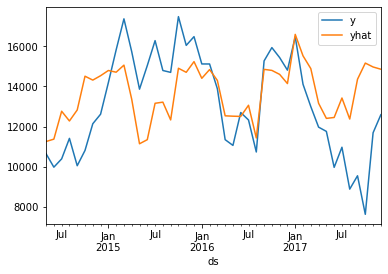

In [46]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

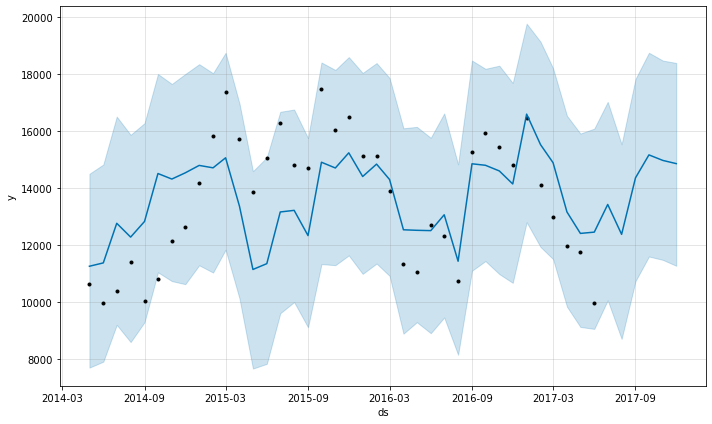

In [47]:
fig1 = m.plot(forecast)

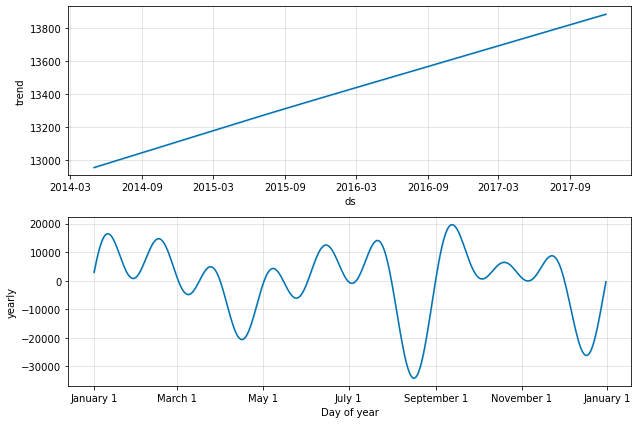

In [48]:
fig2 = m.plot_components(forecast)

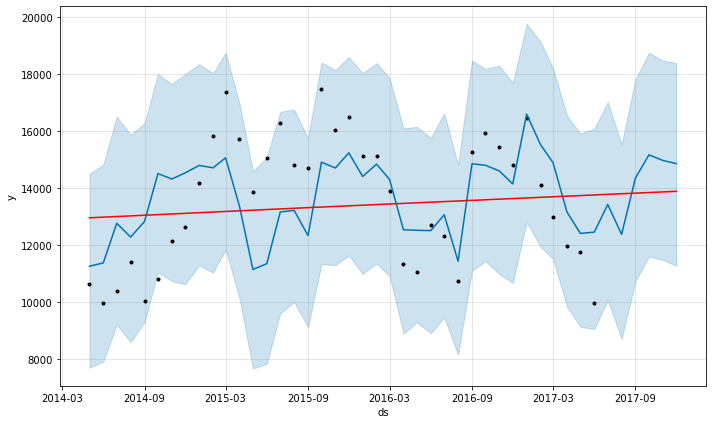

In [49]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [50]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [51]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-06-06 00:00:00 and 2017-02-01 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds          yhat    yhat_lower    yhat_upper          y     cutoff
0  2016-07-01  23543.165789  21462.483052  25721.335673  12327.174 2016-06-06
1  2016-08-01  25977.320986  23801.559889  28227.858914  10734.525 2016-06-06
2  2016-09-01  18587.220233  16574.927037  20681.947787  15266.799 2016-06-06
3  2016-10-01  11404.638990   9378.472946  13611.248015  15930.027 2016-06-06
4  2016-09-01  24358.904663  21219.332294  27736.353594  15266.799 2016-08-05
5  2016-10-01  13976.638676  10925.241676  17138.959350  15930.027 2016-08-05
6  2016-11-01  13889.648260  10890.528719  17186.702207  15431.985 2016-08-05
7  2016-12-01  10421.122436   7375.307073  13487.001829  14806.746 2016-08-05
8  2016-11-01  15901.343029  12651.137729  19169.463319  15431.985 2016-10-04
9  2016-12-01  10727.147494   7359.683396  13684.111453  14806.746 2016-10-04
10 2017-01-01  16082.445136  13133.746654  19226.155200  16465.167 2016-10-04
11 2017-02-01  24347.652557  21144.782076  27315.190513  14105.358 2016-10-04
12 2017-01-01  14383.605362  11361.908675  17442.117308  16465.167 2016-12-03
13 2017-02-01  24046.440322  21049.982704  27229.742333  14105.358 2016-12-03
14 2017-03-01  16769.888843  13424.622676  19801.308407  12993.138 2016-12-03
15 2017-04-01  14804.678643  11681.195927  17904.537101  11971.080 2016-12-03
16 2017-03-01  16675.157609  13425.379440  19928.167944  12993.138 2017-02-01
17 2017-04-01  14535.138036  11388.600985  17994.076065  11971.080 2017-02-01
18 2017-05-01  13606.469676  10399.096390  16844.343653  11759.049 2017-02-01
19 2017-06-01  14459.519539  11331.799212  17602.445500   9969.651 2017-02-01

In [52]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   27 days  1.042324e+08  10209.428417  10154.048726  0.752703  0.752703   
1   28 days  6.888783e+06   2624.649058   2075.688819  0.156898  0.156898   
2   29 days  5.610841e+06   2368.721336   2078.625229  0.141660  0.078418   
3   56 days  1.183379e+08  10878.320833   8662.178812  0.773200  0.773200   
4   57 days  1.180793e+08  10866.428930   8598.092155  0.771301  0.771301   
5   58 days  1.022942e+07   3198.347222   3016.493415  0.199073  0.199073   
6   59 days  1.160876e+07   3407.162865   3321.828271  0.244855  0.244855   
7   60 days  5.269976e+07   7259.459737   6252.570179  0.459481  0.459481   
8   87 days  5.492516e+07   7411.150886   6630.751777  0.461133  0.461133   
9   88 days  8.321325e+06   2884.670653   2659.543792  0.195308  0.195308   
10  89 days  1.779720e+06   1334.061314   1115.071270  0.090175  0.090175   
11 117 days  1.112943e+07   3336.079752   2820.229640  0.187127  0.153662   
12 118 days  1.985642e+07   4456.053786   4455.505787  0.290135  0.290135   
13 119 days  1.363149e+07   3692.084459   3609.611103  0.266447  0.266447   
14 120 days  6.253176e+07   7907.702488   7366.081548  0.588241  0.588241   

    coverage  
0       0.00  
1       0.50  
2       0.75  
3       0.50  
4       0.50  
5       0.50  
6       0.50  
7       0.50  
8       0.00  
9       0.50  
10      1.00  
11      0.50  
12      0.00  
13      0.50  
14      0.00

In [53]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [54]:
forecast_FBP

yhat
MONTH                   
2017-07-01  13421.033188
2017-08-01  12374.035292
2017-09-01  14354.518277
2017-10-01  15159.136751
2017-11-01  14965.240566
2017-12-01  14853.026036

In [55]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [56]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-07-01   -2450.429188
2017-08-01   -3487.768292
2017-09-01   -4804.375277
2017-10-01   -7526.965751
2017-11-01   -3274.483566
2017-12-01   -2263.493036
dtype: float64

In [57]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 4354.1552843398695


In [58]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

2450.4291882695925


In [59]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

42.750336487295

# Auto Arima

In [60]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [61]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,1)[6]             : AIC=761.969, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=776.674, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=767.489, Time=0.17 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=755.201, Time=0.35 sec
 ARIMA(0,2,1)(0,0,0)[6]             : AIC=753.302, Time=0.44 sec
 ARIMA(0,2,1)(1,0,0)[6]             : AIC=755.220, Time=0.33 sec
 ARIMA(0,2,1)(1,0,1)[6]             : AIC=756.705, Time=0.72 sec
 ARIMA(1,2,1)(0,0,0)[6]             : AIC=755.236, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[6]             : AIC=755.222, Time=0.52 sec
 ARIMA(1,2,0)(0,0,0)[6]             : AIC=765.987, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[6]             : AIC=inf, Time=0.89 sec
 ARIMA(0,2,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.40 sec

Best model:  ARIMA(0,2,1)(0,0,0)[6]          
Total fit time: 4.706 seconds


In [62]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -374.651
Date:                Wed, 23 Jun 2021   AIC                            753.302
Time:                        14:03:51   BIC                            756.778
Sample:                             0   HQIC                           754.576
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9030      0.092     -9.837      0.000      -1.083      -0.723
sigma2       3.07e+06   7.89e+05      3.891      0.000    1.52e+06    4.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 7.94
Prob(Q):                              0.49   Prob(JB):                         0.02
Heteroskedasticity (H):               1.21   Skew:                             0.92
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
ABC_df_Pesticides_AA

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [64]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [65]:
train

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651

In [66]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [67]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [68]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [69]:
#Printing the forecast values in the test set
forecast

(array([9449.89766929, 8930.14433858, 8410.39100788, 7890.63767717,
        7370.88434646, 6851.13101575]),
 array([[ 6199.76556243, 12700.02977616],
        [ 3988.20425033, 13872.08442684],
        [ 1927.71366346, 14893.06835229],
        [  -97.93078281, 15879.20613715],
        [-2128.90509752, 16870.67379044],
        [-4183.28297198, 17885.54500349]]))

In [70]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [71]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                  
2017-07-01  9449.897669
2017-08-01  8930.144339
2017-09-01  8410.391008
2017-10-01  7890.637677
2017-11-01  7370.884346
2017-12-01  6851.131016

<AxesSubplot:xlabel='MONTH'>

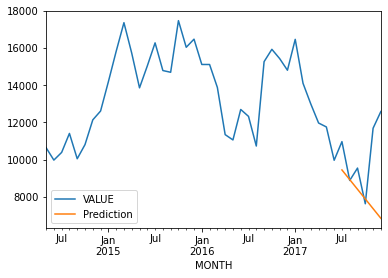

In [72]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [73]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([9449.89766929, 8930.14433858, 8410.39100788, 7890.63767717,
        7370.88434646, 6851.13101575]),
 array([[ 6199.76556243, 12700.02977616],
        [ 3988.20425033, 13872.08442684],
        [ 1927.71366346, 14893.06835229],
        [  -97.93078281, 15879.20613715],
        [-2128.90509752, 16870.67379044],
        [-4183.28297198, 17885.54500349]]))

In [74]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [75]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [76]:
forecast1_df

Prediction
2017-07-01  9449.897669
2017-08-01  8930.144339
2017-09-01  8410.391008
2017-10-01  7890.637677
2017-11-01  7370.884346
2017-12-01  6851.131016

<AxesSubplot:>

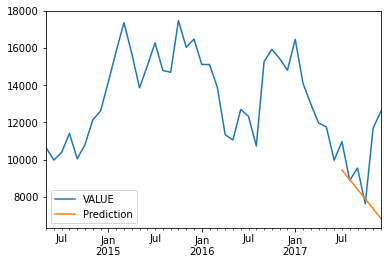

In [77]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [78]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

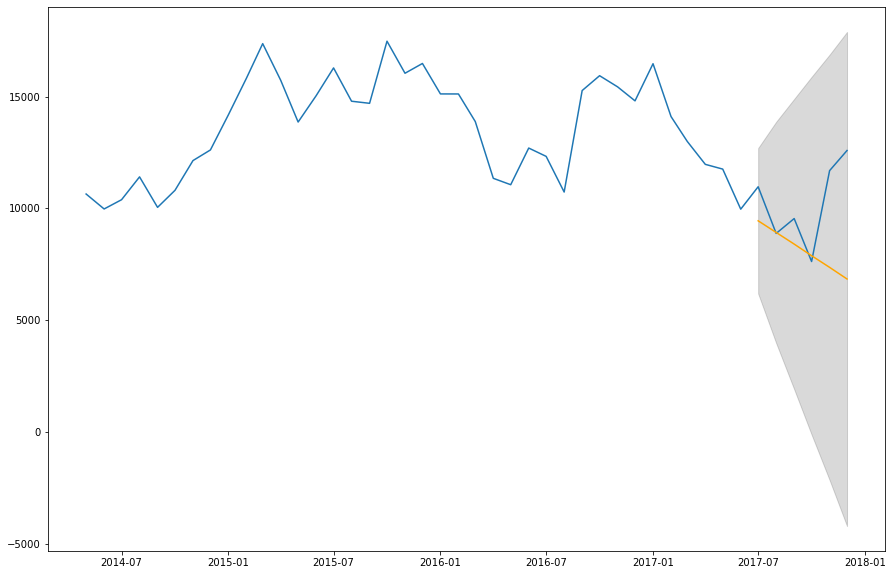

In [79]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


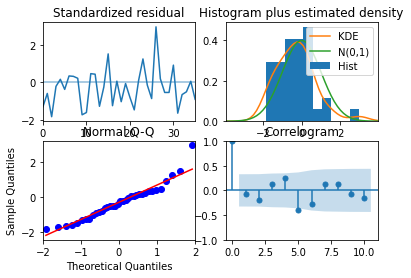

In [80]:
out = model.plot_diagnostics()

In [81]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-07-01    1520.706331
2017-08-01     -43.877339
2017-09-01    1139.751992
2017-10-01    -258.466677
2017-11-01    4319.872654
2017-12-01    5738.401984
dtype: float64

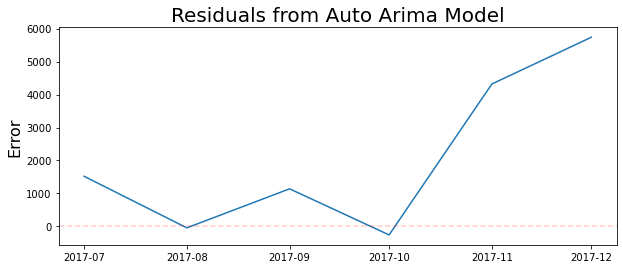

In [82]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

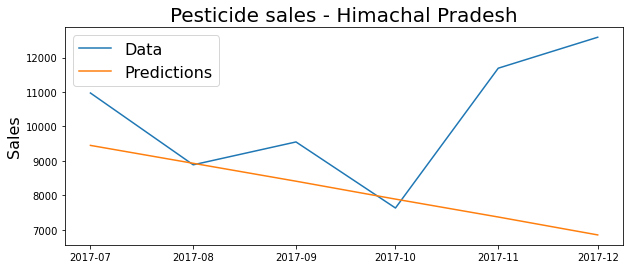

In [83]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [84]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 3035.096639522313


In [85]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

2170.1794960615016


In [86]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

18.701378098671416

# ARMA model

In [87]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

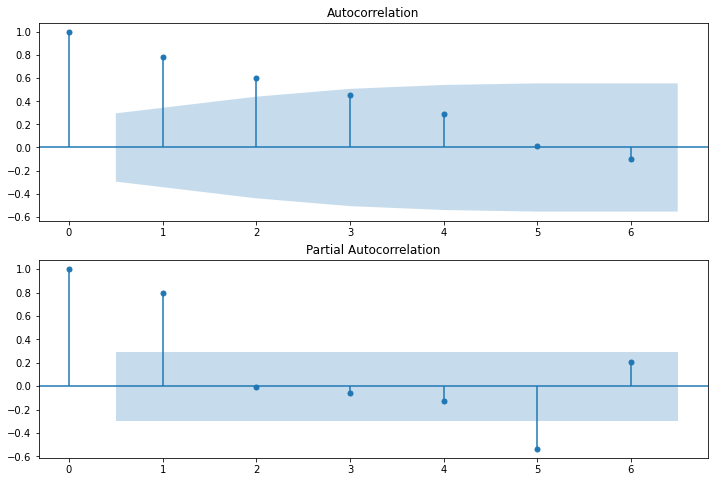

In [88]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [89]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [90]:
train

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651

In [91]:
# define model
model = ARMA(train, order=(1,1))

In [92]:
model_fit = model.fit()

In [93]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   38
Model:                     ARMA(1, 1)   Log Likelihood                -330.712
Method:                       css-mle   S.D. of innovations           1438.027
Date:                Wed, 23 Jun 2021   AIC                            669.425
Time:                        14:04:06   BIC                            675.975
Sample:                    05-01-2014   HQIC                           671.755
                         - 06-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.315e+04    978.700     13.433      0.000    1.12e+04    1.51e+04
ar.L1.VALUE     0.7377      0.162      4.544      0.000       0.420       1.056
ma.L1.VALUE     0.1309      0.261      0.502    

In [94]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


In [96]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [97]:
predictions

2017-07-01    10527.925088
2017-08-01    11214.884838
2017-09-01    11721.650756
2017-10-01    12095.488808
2017-11-01    12371.266804
2017-12-01    12574.706510
Freq: MS, dtype: float64

In [98]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [99]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


0
2017-07-01  10527.925088
2017-08-01  11214.884838
2017-09-01  11721.650756
2017-10-01  12095.488808
2017-11-01  12371.266804
2017-12-01  12574.706510

In [100]:
Pred_df.columns = ['PRED_VALUE']

In [101]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-07-01     442.678912
2017-08-01   -2328.617838
2017-09-01   -2171.507756
2017-10-01   -4463.317808
2017-11-01    -680.509804
2017-12-01      14.826490
dtype: float64

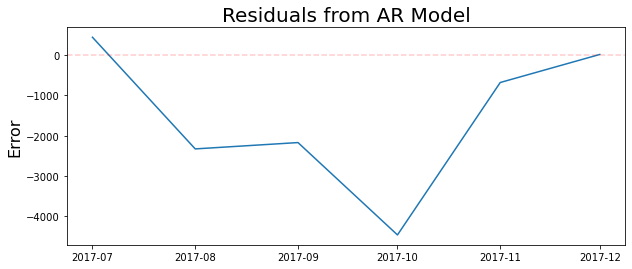

In [102]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

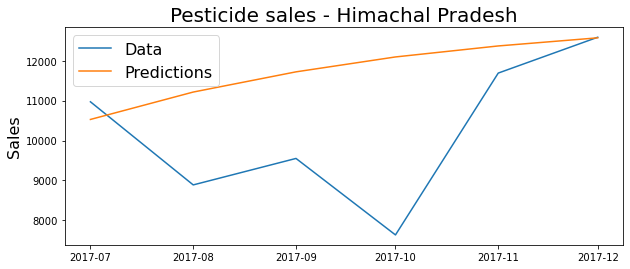

In [103]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [104]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 2262.6824369983697


In [105]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1683.5764348417908


In [106]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.566130836651794

# SARIMAX Model

In [107]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [108]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15628004695935
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15628004695935
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15628004695935
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.8561739739254
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.8561739739254
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.8561739739254
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555939121024
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555939121024
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555939121024
ARIMA(0, 0,

In [109]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [110]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8168   1305.698      0.001      1.000   -2558.305    2559.938
ar.S.L24      -0.6691   3806.937     -0.000      1.000   -7462.129    7460.791
ma.S.L12      -1.2743    464.296     -0.003      0.998    -911.277     908.729
ma.S.L24       0.6362   6089.673      0.000      1.000   -1.19e+04    1.19e+04
sigma2      1.739e+07      1.546   1.12e+07      0.000    1.74e+07    1.74e+07


In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   44
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -195.318
Date:                       Wed, 23 Jun 2021   AIC                            400.635
Time:                               14:06:00   BIC                            405.614
Sample:                           05-01-2014   HQIC                           401.607
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8168   1305.698      0.001      1.000   -2558.305    2559.938
ar.S.L24      -0.6691   3806.937     -0.000      1.000   -7462.129    7460.791
ma.S.L12      -1.2743    464.296     -0.003      0.998    -911.277     908.729
ma.S.L24       0.6362   6089.673      0.000      1.000   -1.19e+04    1.19e+04
sigma2      1.739e+07      1.546   1.12e+07      0.000    1.74e+07    1.74e+07
===================================================================================
Ljung-Box (L1) (Q):                  10.38   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               0.94   Skew:                             0.37
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+23. Standard errors may be unstable.
"""

In [112]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1440x1440 with 0 Axes>

In [113]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [114]:
forecast = results.predict(12)
forecast

2015-05-01    19720.568849
2015-06-01    18483.860380
2015-07-01    19248.901202
2015-08-01    21137.922375
2015-09-01    18617.143624
2015-10-01    20026.145068
2015-11-01    22486.958862
2015-12-01    23366.478238
2016-01-01    26278.454564
2016-02-01    29298.807923
2016-03-01    32158.871301
2016-04-01    29128.815522
2016-05-01    14572.480119
2016-06-01    17397.614281
2016-07-01    19250.400861
2016-08-01    15498.102974
2016-09-01    16705.081003
2016-10-01    21007.835109
2016-11-01    17045.848751
2016-12-01    17363.557449
2017-01-01    13285.648330
2017-02-01    11631.824385
2017-03-01     7814.263430
2017-04-01     4836.034831
2017-05-01     9477.491116
2017-06-01    11146.483166
2017-07-01     9566.514130
2017-08-01     8305.389720
2017-09-01    15810.382628
2017-10-01    14787.795297
2017-11-01    15405.157160
2017-12-01    14076.586432
Freq: MS, Name: predicted_mean, dtype: float64

In [115]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

Empty DataFrame
Columns: [PRED_VALUE]
Index: []

<AxesSubplot:>

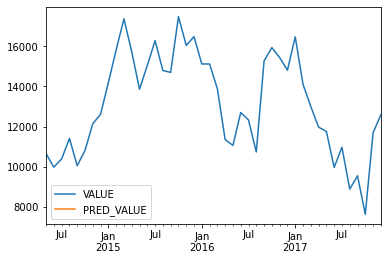

In [116]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [117]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-07-01     442.678912
2017-08-01   -2328.617838
2017-09-01   -2171.507756
2017-10-01   -4463.317808
2017-11-01    -680.509804
2017-12-01      14.826490
dtype: float64

In [118]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    18352.232182
2018-02-01    14676.615699
2018-03-01    14128.957309
2018-04-01    14161.314104
2018-05-01    14861.390447
2018-06-01    11015.277980
Freq: MS, Name: predicted_mean, dtype: float64

In [119]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 2262.6824369983697


In [120]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1683.5764348417908


In [121]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.566130836651794

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [122]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [123]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [124]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [150]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 6 months

y_pred1 =  pred1.forecast(steps = 6)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.7524
Smoothing Slope:  0.0147
Smoothing Seasonal:  0.2428
Initial Level:  11788.3619
Initial Slope:  -321.5926
Initial Seasons:  [-1079.495  -1760.8478 -1410.1002  -524.3907 -1682.1888  -902.0129
   313.5975   837.283   2375.9829  3905.43    5351.2028  3686.3112]

                  Y_hat          Y
MONTH                             
2017-07-01  9180.626280  10970.604
2017-08-01  8552.575714   8886.267
2017-09-01  9282.480303   9550.143
2017-10-01  9233.539445   7632.171
2017-11-01  8926.355782  11690.757
2017-12-01  9321.940716  12589.533


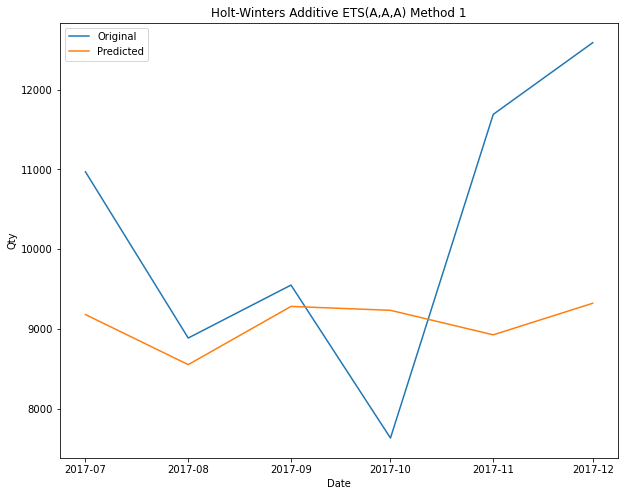

In [151]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [127]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-07-01    1789.977720
2017-08-01     333.691286
2017-09-01     267.662697
2017-10-01   -1601.368445
2017-11-01    2764.401218
2017-12-01    3267.592284
dtype: float64

In [128]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 2011.237917330402


In [129]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

1670.7822750173757


In [130]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f,  MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.75,  MAPE is 15.58


In [145]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [146]:
pred=final_model.forecast(12)
pred

2018-01-01    13986.297540
2018-02-01    14879.773234
2018-03-01    16540.440968
2018-04-01    16217.810872
2018-05-01    14278.249921
2018-06-01    12881.467480
2018-07-01    12901.294361
2018-08-01    11981.539097
2018-09-01    13317.006455
2018-10-01    13236.459192
2018-11-01    14798.287417
2018-12-01    14755.895726
Freq: MS, dtype: float64

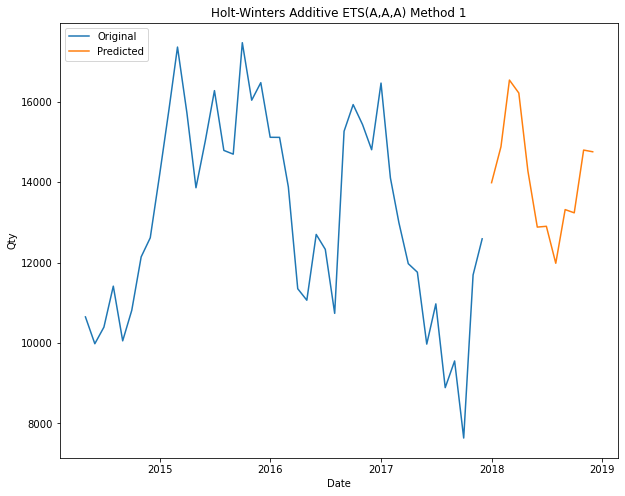

In [147]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [134]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [135]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 1:]

Text(0, 0.5, 'Sales')

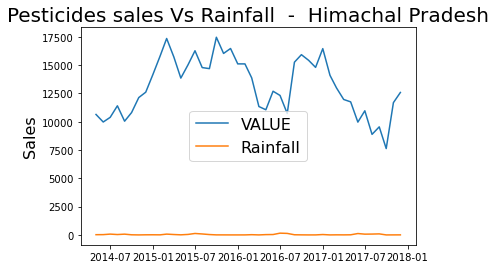

In [136]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [137]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [138]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<AxesSubplot:xlabel='MONTH'>, <AxesSubplot:xlabel='MONTH'>],
      dtype=object)

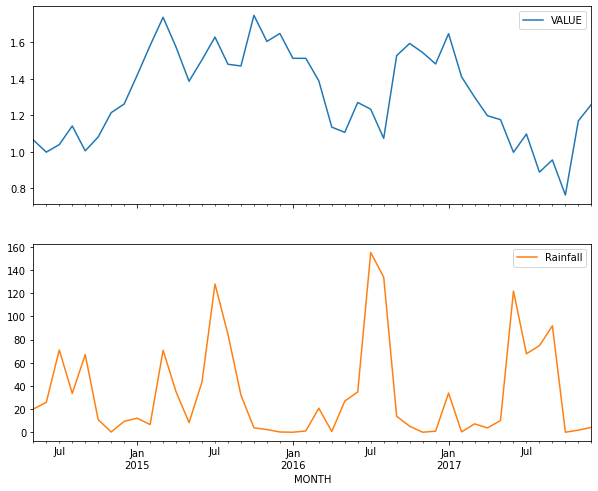

In [139]:
ABC_df_Pesticides.plot(subplots=True)

<AxesSubplot:xlabel='MONTH'>

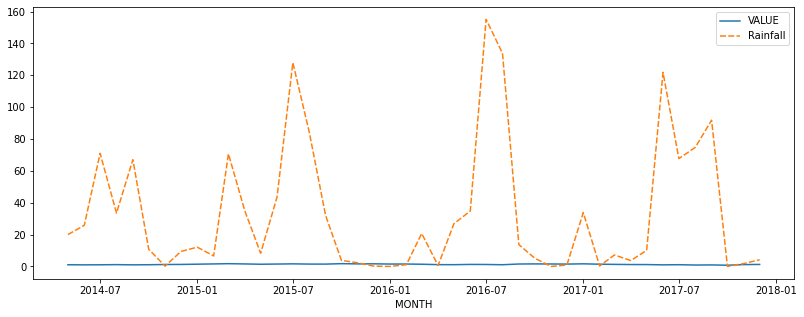

In [140]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [141]:
#to find the coorelation betwween Rainfall and Value

In [142]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [143]:
correlation = col1.corr(col2)
correlation

-0.23316400228697773

<AxesSubplot:>

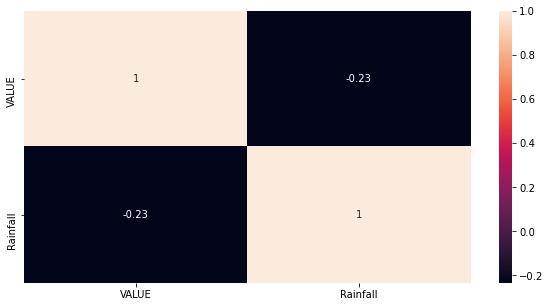

In [144]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)